# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from PIL import Image

In [2]:
# Read the Mapbox API key
load_dotenv("map.env")
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [3]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

neighborhoods_coord=pd.read_csv(Path("Data/neighborhoods_coordinates.csv")).drop_duplicates()
neighborhoods_coord.set_index("Neighborhood",inplace=True)
neighborhoods_coord=neighborhoods_coord.rename(columns={"Neighborhood":"neighborhood"})

sfo_average_data=(sfo_data[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].groupby([sfo_data.index,'neighborhood']).mean().reset_index())
sfo_neighborhood=(sfo_data[['neighborhood','sale_price_sqr_foot']].groupby(['neighborhood']).mean())

sfo_expensive_areas=sfo_data[['sale_price_sqr_foot','housing_units','gross_rent','neighborhood']].groupby('neighborhood').mean()
sfo_expensive_areas=sfo_expensive_areas.sort_values("sale_price_sqr_foot",ascending=False)
sfo_expensive_areas.reset_index(inplace=True)
sfo_expensive_areas=sfo_expensive_areas.head(10)
sfo_rent_vs_price=sfo_data[sfo_data["neighborhood"].isin(sfo_expensive_areas["neighborhood"])]

avg_neighborhood=(sfo_data[['neighborhood','sale_price_sqr_foot','housing_units','gross_rent']].groupby(['neighborhood']).mean())
neighborhoods=pd.concat([neighborhoods_coord,avg_neighborhood],axis=1,join="inner")
df_expensive_neighborhoods_per_year = sfo_expensive_areas[sfo_expensive_areas["neighborhood"].isin(sfo_rent_vs_price["neighborhood"])]

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [4]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    return sfo_average_data.hvplot(
    kind='bar',
    x='year',
    y='housing_units',
    groupby='neighborhood',
    color='green',
    ylim=(sfo_average_data['housing_units'].min()-5000,sfo_average_data['housing_units'].max()+5000),
    yformatter='%.0f',
    title="Housing Units",
    xlabel="Year",
    ylabel="Housing Units",
    width=1200)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    return sfo_average_data.hvplot(x='year',y='gross_rent',groupby='neighborhood',color='navy',title="Average Monthly Rent",xlabel="Year",ylabel="Average Rent").opts(yformatter="%.0f")




def average_sales_price():
    """Average Sales Price Per Year."""
    return sfo_average_data.hvplot(x='year',y='sale_price_sqr_foot',groupby='neighborhood',color='red',title="Price per SqFt by Neighborhood per Year",xlabel="Year",ylabel="Price Per SqFt")



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    return sfo_neighborhood.hvplot.bar(
    x="neighborhood",
    y="sale_price_sqr_foot",
    color='sale_price_sqr_foot',
    rot=90,
    height=700,
    width=1500,
    title="Average Price by Neighborhood",
    xlabel="Neighborhoods",
    ylabel="Average Price per SqFt"
    )



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    return sfo_rent_vs_price.hvplot.bar('year',['sale_price_sqr_foot','gross_rent'],xlabel="neighborhood",ylabel="Housing Units",
                  groupby="neighborhood",fontsize=10,rot=90,height=700,width=1200)
    


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    return sfo_rent_vs_price.hvplot(x='year',y='sale_price_sqr_foot',groupby='neighborhood',color='red',title="Price per SqFt by Neighborhood per Year",xlabel="Year",ylabel="Price Per SqFt")+sfo_rent_vs_price.hvplot(x='year',y='gross_rent',groupby='neighborhood',color='navy',title="Average Rent by Neighborhood per Year",xlabel="Year",ylabel="Average Rent")

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    return px.parallel_coordinates(
    df_expensive_neighborhoods_per_year, 
    dimensions=("sale_price_sqr_foot","housing_units","gross_rent"),
    labels={"sale_price_sqr_foot":"Price per SqFt","housing_units":"Housing Units","gross_rent":"Average Rent"},
    color='sale_price_sqr_foot',
    title="Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods")



def parallel_categories():
    """Parallel Categories Plot."""
    return px.parallel_categories(
df_expensive_neighborhoods_per_year,
dimensions=["neighborhood","gross_rent","sale_price_sqr_foot","housing_units"],
labels={"sale_price_sqr_foot":"Price per SqFt","housing_units":"Housing Units","gross_rent":"Average Rent","neighborhood":"Neighborhood"},
color="sale_price_sqr_foot",
color_continuous_scale=px.colors.sequential.Inferno,
title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods",
width=900,
height=500,
)

def neighborhood_map():
    """Neighborhood Map."""
    map_plot=px.scatter_mapbox(
neighborhoods,
lat="Lat",
lon="Lon",
size="sale_price_sqr_foot",
color='gross_rent',
zoom=10 
)
    return map_plot

def sunburst():
    """Sunburst Plot."""
    return px.sunburst(
sfo_rent_vs_price.reset_index(),
path=['year','neighborhood'],
values='sale_price_sqr_foot',
color='gross_rent',
color_continuous_scale=px.colors.sequential.Blues,
title="Cost Analysis of Most Expensive Neighborhoods in San Francisco",
labels={"gross_rent","Average Rent"},
height=800,
width=900
)


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Tabs
    [0] Column
        [0] Markdown(str)
        [1] PNG(JpegImageFile)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Plotly(Figure)
    [1] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [2] Column
        [0] Row
            [0] HoloViews(Layout)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                [1] VSpacer()
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [4] Column
        [0] Plotly(Figure)
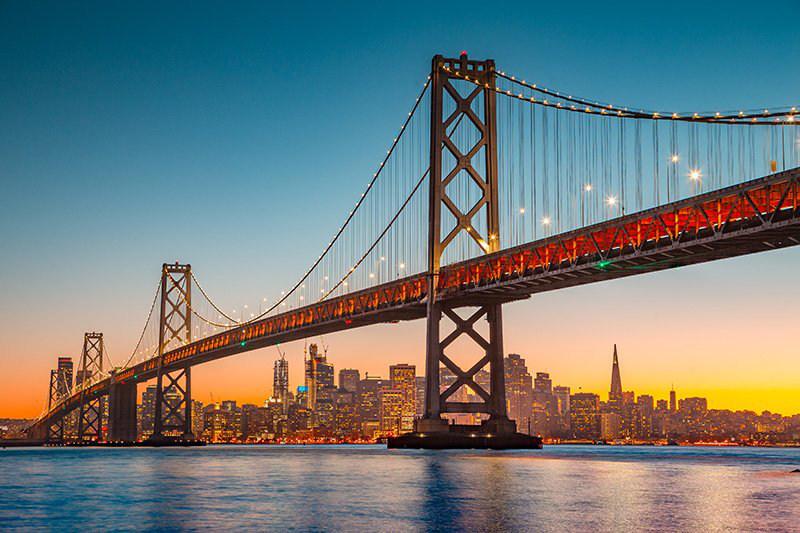

In [5]:
# Create a Title & Cplumns for the Dashboard
dashboard_title = "#Housing Cost in San Francision (2010 - 2016)"
dashboard_desc = "### This is a dashboard consolidating the different costs metrics per neighborhood in San Francisco using visualization techniques learnt in the FinTech Bootcamp!"
image=Image.open("Images/sanfrancisco.jpg")
welcome=pn.Column(dashboard_title,image,dashboard_desc,"#### Click the above tabs to look at the data collected on San Francisco! Averages is to see the average rent, price per square foot and housing units. Expensive Neighborhoods is the average price per square foot, rent, and in which neighborhoods. Finally, the Map tab is a map visualization of the neighborhoods in San Francisco and the average price per square foot cost in each one!",neighborhood_map())
san_fran_data=pn.Column(average_sales_price(), average_gross_rent(),housing_units_per_year())
san_fran_comp=pn.Column(most_expensive_neighborhoods_rent_sales(),top_most_expensive_neighborhoods(),average_price_by_neighborhood())
san_fran_parallel=pn.Column(parallel_categories(),parallel_coordinates())
san_fran_sunburst=pn.Column(sunburst())
# Create a tab layout for the dashboard
san_francisco_dashboard=pn.Tabs(("Welcome",welcome),("Averages",san_fran_data),('Nieghborhood Analysis',san_fran_comp),('Parallel Plots Analysis',san_fran_parallel),('Sunburst',san_fran_sunburst))
# Create the dashboard
san_francisco_dashboard.servable()

## Serve the Panel Dashboard

In [6]:
# Serve the# dashboard
!panel serve dashboard_webapps.ipynb --log-level debug --show

ERROR: Path for Bokeh server application does not exist: C:\Users\Siegfried Vieluf\Desktop\Finance BootCamp\PyViz\PyViz_Assignment\dashboard_webapps.ipynb


# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [7]:
# housing_units_per_year()

In [8]:
# average_gross_rent()

In [9]:
# average_sales_price()

In [10]:
# average_price_by_neighborhood()

In [11]:
# top_most_expensive_neighborhoods()

In [12]:
# most_expensive_neighborhoods_rent_sales()

In [13]:
# neighborhood_map().show()

In [14]:
# parallel_categories()

In [15]:
# parallel_coordinates()

In [16]:
# sunburst()